# Whitening

Whitening at LIGO is done using a modelled design curve

This design curve doesn't fit this data. Let's derive a design curve for each detector for the samples without a GW

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import signal
from scipy import fft
import torch
import torchaudio
from torchaudio.functional import amplitude_to_DB
from nnAudio import Spectrogram
import pywt
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from pathlib import Path

COMP_NAME = "g2net-gravitational-wave-detection"

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/{COMP_NAME}/")
OUTPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_output/{COMP_NAME}/")

In [2]:
df = pd.read_csv(INPUT_PATH / "training_labels.csv").query("target == 0").reset_index(drop=True)
print(df.shape)
df.head(10)

(280070, 2)


,id,target
0,00001f4945,0
1,0000661522,0
2,00007a006a,0
3,0000c3b9c9,0
4,000118b40d,0
5,0001616241,0
6,0001bfda2f,0
7,0002014fd3,0
8,0002402e11,0
9,000243542d,0


In [3]:
design_curve = pd.read_csv(INPUT_PATH / "aLIGODesign.txt", sep="\s+", names=["freq", "strain"])
design_curve

,freq,strain
0,5.0000,1.999700e-20
1,5.0115,1.946200e-20
2,5.0231,1.894200e-20
3,5.0347,1.843700e-20
4,5.0463,1.794600e-20
...,...,...
2995,4954.1000,2.441200e-23
2996,4965.6000,2.446800e-23
2997,4977.0000,2.452400e-23
2998,4988.5000,2.458000e-23


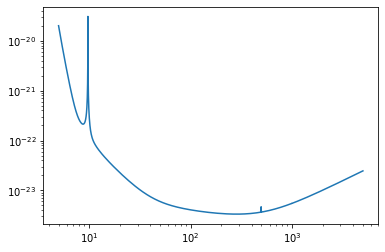

In [4]:
plt.plot(design_curve["freq"], design_curve["strain"])
plt.xscale('log')
plt.yscale('log');

In [5]:
# wave_id = "098a464da9"  # Super clean signal
wave_id = "000a5b6e5c"
# wave_id = "00000e74ad"
# wave_id = "0000a38978"

In [6]:
def load_file(id_, folder="train", norm=False):
    path = INPUT_PATH / folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
    waves = np.load(path)
    return waves


def plot_periodogram(data, channel=0):
    freq, pxx = signal.periodogram(data[channel], fs=2048)

#     plt.figure(figsize=(20, 10))
    plt.plot(freq[20:], pxx[20:]**0.5)
    plt.plot(design_curve["freq"], design_curve["strain"])
#     plt.ylim([1e-50, 1e-38])
    plt.xscale('log')
    plt.yscale('log')

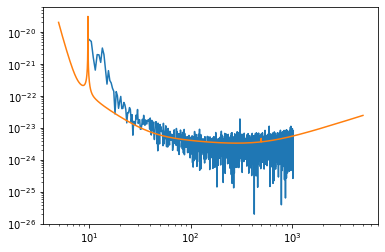

In [7]:
plot_periodogram(load_file(df.loc[0, "id"]))

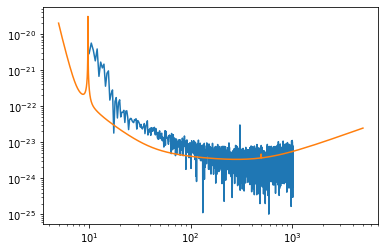

In [8]:
plot_periodogram(load_file(df.loc[1, "id"]))

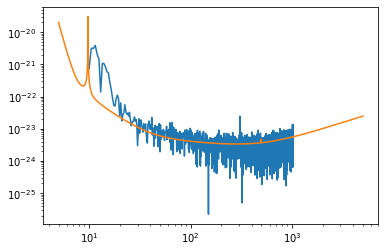

In [9]:
plot_periodogram(load_file(df.loc[2, "id"]))

In [10]:
data = load_file(df.loc[2, "id"])
freq, pxx = signal.periodogram(data[0], fs=2048)
freq

array([0.0000e+00, 5.0000e-01, 1.0000e+00, ..., 1.0230e+03, 1.0235e+03,
       1.0240e+03])

# Build new design curve

In [11]:
hanford = 0
livingston = 0
virgo = 0
n = len(df)
window = ("tukey", 0.2)

for i in tqdm(df["id"]):
    data = load_file(i)
    hanford += signal.periodogram(data[0], fs=2048, window=window)[1]
    livingston += signal.periodogram(data[1], fs=2048, window=window)[1]
    virgo += signal.periodogram(data[2], fs=2048, window=window)[1]

hanford /= n
livingston /= n
virgo /= n

design_curves_welch = np.stack([hanford, livingston, virgo])[:, :-1] ** 0.5

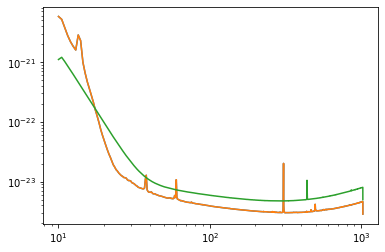

In [12]:
plt.plot(freq[20:], hanford[20:]**0.5)
plt.plot(freq[20:], livingston[20:]**0.5)
plt.plot(freq[20:], virgo[20:]**0.5)
# plt.plot(freq[20:], pxx[20:]**0.5)
plt.xscale('log')
plt.yscale('log')

In [13]:
hanford[-5:]

array([2.12857242e-47, 2.12862103e-47, 2.12077884e-47, 2.12741643e-47,
       8.19668719e-48])

In [14]:
freq[-5:]

array([1022. , 1022.5, 1023. , 1023.5, 1024. ])

In [15]:
# hanford_v2 = 0
# livingston_v2 = 0
# virgo_v2 = 0
# n = len(df)

# for i in tqdm(df["id"]):
#     data = load_file(i)
#     hanford_v2 += signal.periodogram(data[0], fs=2048, window=window)[1]**0.5
#     livingston_v2 += signal.periodogram(data[1], fs=2048, window=window)[1]**0.5
#     virgo_v2 += signal.periodogram(data[2], fs=2048, window=window)[1]**0.5
    
# hanford_v2 /= n
# livingston_v2 /= n
# virgo_v2 /= n

In [16]:
# plt.plot(freq[20:], hanford_v2[20:])
# plt.plot(freq[20:], livingston_v2[20:])
# plt.plot(freq[20:], virgo_v2[20:])
# # plt.plot(freq[20:], pxx[20:]**0.5)
# plt.xscale('log')
# plt.yscale('log')

In [17]:
# plt.plot(freq[20:], hanford[20:]**0.5)
# plt.plot(freq[20:], hanford_v2[20:])
# plt.xscale('log')
# plt.yscale('log')

In [18]:
# psd = 0
# window_np = signal.get_window(window, 4096)

# for i in tqdm(df["id"]):
#     data = load_file(i)
#     psd += fft.fft(data * window_np)

# psd /= len(df)
# design_curves = np.sqrt(np.real(psd * np.conj(psd)))
# print(design_curves.shape)

# plt.plot(design_curves.T)
# plt.xscale('log')
# plt.yscale('log')

In [19]:
data = load_file(df.loc[0, "id"])
data_tensor = torch.tensor(data)
freq, pxx = signal.periodogram(data[0], fs=2048)

In [20]:
psd = 0
window_pt = torch.tensor(signal.get_window(window, 4096))

for i in tqdm(df["id"]):
    data = torch.tensor(load_file(i))
    psd += torch.fft.fft(data * window_pt)

psd /= len(df)
design_curves = torch.sqrt(torch.real(psd * torch.conj(psd)))

In [21]:
design_curves.shape

torch.Size([3, 4096])

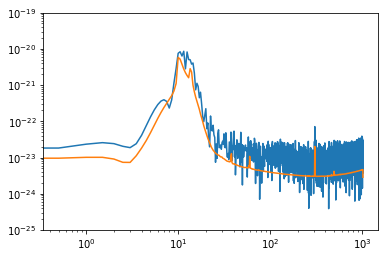

In [22]:
N = 4096
freq_t = torch.fft.fftfreq(N, 1/2048)[:N//2]

plt.plot(freq_t, design_curves.numpy().T[:N//2, 0]);
plt.plot(freq, hanford**0.5)
# plt.plot(freq, livingston**0.5)
# plt.plot(freq, virgo**0.5)
plt.ylim([1e-25, 1e-19])
plt.xscale('log')
plt.yscale('log')

In [23]:
freq

array([0.0000e+00, 5.0000e-01, 1.0000e+00, ..., 1.0230e+03, 1.0235e+03,
       1.0240e+03])

In [24]:
data_tensor

tensor([[-1.2656e-21, -9.9824e-22, -1.1199e-21,  ..., -8.5021e-22,
         -1.1164e-21, -1.0776e-21],
        [ 5.5544e-22,  2.2186e-22, -3.8980e-22,  ...,  1.1493e-21,
          1.0929e-21,  8.1230e-22],
        [-1.4537e-21, -1.0384e-21, -1.3569e-21,  ...,  4.3694e-22,
          4.4233e-22,  8.5153e-22]], dtype=torch.float64)

In [25]:
torch.fft.fftfreq(4096, 1/2048)[:4096//2]

tensor([0.0000e+00, 5.0000e-01, 1.0000e+00,  ..., 1.0225e+03, 1.0230e+03,
        1.0235e+03])

# Whiten data

In [26]:
design_curves_welch = torch.tensor(design_curves_welch)
design_curves_welch.shape

torch.Size([3, 2048])

In [130]:
def apply_whiten(signal, design_curves):
    spec = torch.fft.fft(signal)
    n = signal.shape[-1]
    dc_len = design_curves.shape[-1]
    whitened = torch.real(torch.fft.ifft(spec[:, :dc_len] / design_curves, n=n))
    whitened *= np.sqrt(n / 2)
    whitened /= torch.max(torch.abs(whitened), axis=1)[0].reshape(3, 1)
    return whitened.to(dtype=torch.float32)


data = torch.tensor(load_file(wave_id)) * window_pt
# data = torch.tensor(load_file("00000e74ad")) * window_pt
# data = torch.tensor(load_file("098a464da9")) * window_pt
# data = torch.tensor(load_file("7945e449f3")) * window_pt
whitened = apply_whiten(data, design_curves_welch)
whitened.shape

torch.Size([3, 4096])

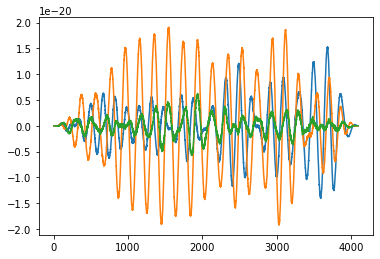

In [131]:
plt.plot(data.numpy().T);

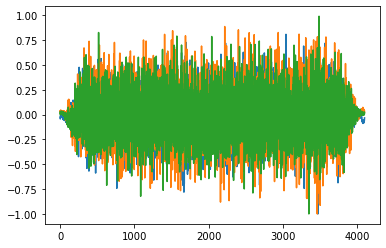

In [132]:
plt.plot(whitened.numpy().T);

In [133]:
SR = 2048
N = 4

transform = Spectrogram.CQT1992v2(
    sr=SR,
    fmin=15,
    fmax=1000,
    hop_length=8,  # img width = 4096 / hop_length
    bins_per_octave=12 * N,  # fs=0.5 & bpo=24 is the same as fs=1.0 and bpo=12 but with more rows (oversampling)
    filter_scale=1.0 / N,
#     norm=2,
    trainable=False,  # This is interesting...
#     window="parzen",
    window="flattop",
)

CQT kernels created, time used = 0.0577 seconds


/home/anjum/anaconda3/envs/kaggle/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


torch.Size([3, 291, 513])


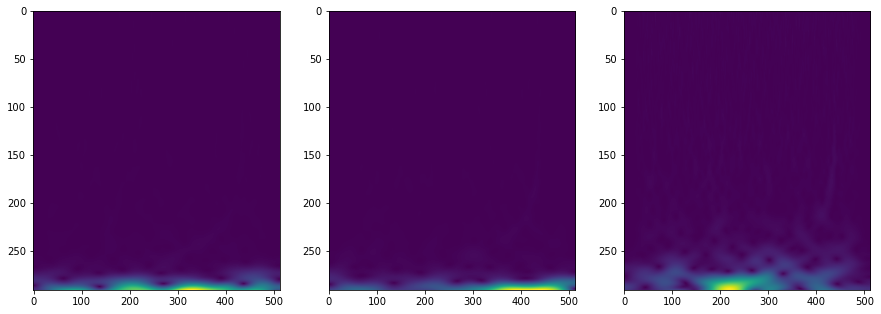

In [134]:
spec_raw = transform(data.float())
spec_raw = torch.flip(spec_raw, [1])
print(spec_raw.shape)

fig, axs = plt.subplots(ncols=3, figsize=(15, 15))
for i in range(3):
    axs[i].imshow(spec_raw[i], aspect=8 / N)

torch.Size([3, 291, 513])


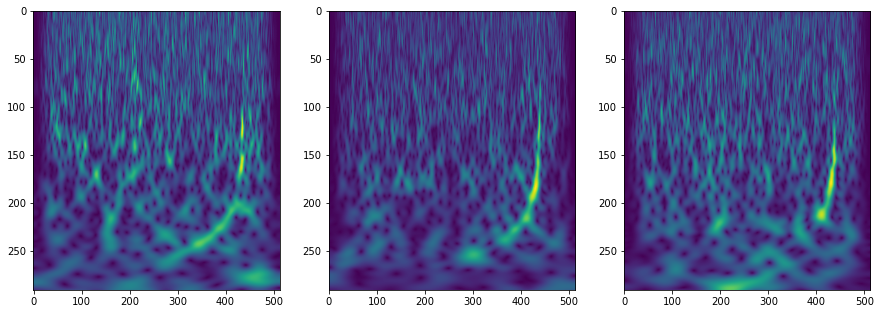

In [135]:
spec_white = transform((whitened / whitened.max()).float())
spec_white = torch.flip(spec_white, [1])
print(spec_white.shape)

fig, axs = plt.subplots(ncols=3, figsize=(15, 15))
for i in range(3):
    axs[i].imshow(spec_white[i], aspect=8 / N)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


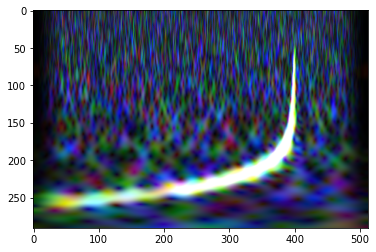

In [120]:
plt.imshow(torch.permute(spec_white, (1, 2, 0)).numpy(), aspect="auto");